In [171]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
import re
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

np.random.seed(7)

In [172]:
df = pd.read_csv('../data/combined_reddit.csv')
df.fillna('', inplace = True)
print(df.shape)
df.head()

(7978, 4)


,author,subreddit,cleantext,cleantitle
0,AutoModerator,soccer,a place to discuss everything except the engli...,non-pl daily discussion
1,Chapulana,soccer,,[about the latest eca/uefa idea] psg want cham...
2,joaorsilva,soccer,,[record] cristiano ronaldo says he will be at ...
3,klarstartpirat,soccer,,jack grealish says english players get unfair ...
4,ImamZain,soccer,,[pearce] the battle for jude bellingham… dortm...


In [173]:
df['subreddit'] = df['subreddit'].map({'soccer':1, 'FIFA':0})
print(df.head())
print(df.tail())

           author  subreddit  \
0   AutoModerator          1   
1       Chapulana          1   
2      joaorsilva          1   
3  klarstartpirat          1   
4        ImamZain          1   

                                           cleantext  \
0  a place to discuss everything except the engli...   
1                                                      
2                                                      
3                                                      
4                                                      

                                          cleantitle  
0                            non-pl daily discussion  
1  [about the latest eca/uefa idea] psg want cham...  
2  [record] cristiano ronaldo says he will be at ...  
3  jack grealish says english players get unfair ...  
4  [pearce] the battle for jude bellingham… dortm...  
                   author  subreddit  \
7973  AdamMitchellWheyyyy          0   
7974          Access_Kind          0   
7975             Yak

### Baseline Model

In [256]:
df['subreddit'].value_counts()

0    4000
1    3978
Name: subreddit, dtype: int64

In [174]:
df['subreddit'].value_counts(normalize=True)

0    0.501379
1    0.498621
Name: subreddit, dtype: float64

Because we have roughly 4000s post from each subreddit, our baseline model will be 50.14%, the higher of the percentages of r/soccer, and r/FIFA. So if we guess either all 'r/FIFA' we will be correct 50.14% of the time.

## Multinomial Naive Bayes

In [175]:
df.head()

,author,subreddit,cleantext,cleantitle
0,AutoModerator,1,a place to discuss everything except the engli...,non-pl daily discussion
1,Chapulana,1,,[about the latest eca/uefa idea] psg want cham...
2,joaorsilva,1,,[record] cristiano ronaldo says he will be at ...
3,klarstartpirat,1,,jack grealish says english players get unfair ...
4,ImamZain,1,,[pearce] the battle for jude bellingham… dortm...


In [176]:
#Set X and y
X = df['cleantitle'] 
y = df['subreddit']

In [177]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify = y)

In [178]:
print(X.shape)
print(y.shape)

(7978,)
(7978,)


In [179]:
X_train

4897    this is the end. i don’t think i’ll ever be ab...
1871                             nike 2022 world cup kits
6324                      the more i play the worse i get
4503    only thing i’ve enjoyed doing on fifa since fu...
4456    now that fifa 22 is over, how would you review...
                              ...                        
7325                             arsenal past and present
1290    cherry's fixture guide &amp; cheat sheet for s...
102     messi, neymar and mbappé assists to each other...
3113    [optajose] rodrygo goes has been involved in 1...
6949       can my pc run fifa 23 on the highest settings?
Name: cleantitle, Length: 5983, dtype: object

In [180]:
y_train

4897    0
1871    1
6324    0
4503    0
4456    0
       ..
7325    0
1290    1
102     1
3113    1
6949    0
Name: subreddit, Length: 5983, dtype: int64

In [181]:
#Multinomial Naive Bayes (variables are positive integers) and Count Vectorizer Pipeline
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('nb', MultinomialNB())
])

In [182]:
pipe_params = {
    'cvec__stop_words':[None, 'english']
}

In [183]:
gs = GridSearchCV(pipe,
                  param_grid = pipe_params,
                  cv = 5)

In [184]:
gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('nb', MultinomialNB())]),
             param_grid={'cvec__stop_words': [None, 'english']})

In [185]:
print(gs.best_score_)
print(gs.best_params_)

0.9346496117663167
{'cvec__stop_words': None}


In [186]:
print(f'Training Score: {gs.score(X_train, y_train)}')
print(f'Testing Score: {gs.score(X_test, y_test)}')

Training Score: 0.9608891860270767
Testing Score: 0.931328320802005


This model appears to be slightly overfit, but it seems to be a good model. Our traning score is .956, and our testing score is .898. 

In [187]:
preds = gs.predict(X_test)
# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

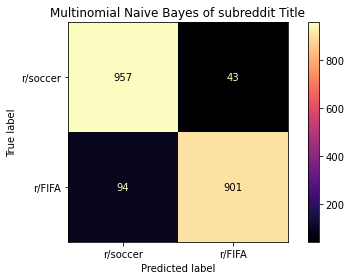

In [188]:
ConfusionMatrixDisplay.from_predictions(y_test, preds, 
                                        cmap = 'magma',
                                       display_labels = ['r/soccer', 'r/FIFA'])
plt.title('Multinomial Naive Bayes of subreddit Title')

plt.tight_layout()
plt.savefig('../images/mnb_title_cmatrix');

In [189]:
#Accuracy
(tp + tn) / (tp + fn + fp + tn)

0.931328320802005

In [190]:
#Sensitivity (Recall)
tp / (tp + fn)

0.9055276381909547

In [191]:
#Specificity
tn / (tn + fp)

0.957

Accuracy score of 93.1% is much greater than our baseline of 50.1%. We have 94 false positives, where we predicted the post was from the r/soccer, but it was actually from r/FIFA, and 43 false negatives, where we predicted the post was from r/FIFA, but it was from r/soccer. 

What did we mispredict?

In [192]:
misplaced_preds = pd.DataFrame([(y_test.values[i], preds[i]) for i in range(len(y_test)) if y_test.values[i] != preds[i]],
             index = [y_test.index[i] for i in range(len(y_test)) if y_test.values[i] != preds[i]])
misplaced_preds.rename(columns = {0:'misplaced_in_FIFA', 1:'misplaced_in_soccer'}, inplace = True)

In [193]:
misplaced_titles = pd.DataFrame(X_test.loc[[y_test.index[i] for i in range(len(y_test)) if y_test.values[i] != preds[i]]])

In [194]:
misplaced_combined_titles = pd.concat([misplaced_preds, misplaced_titles], axis = 1)
misplaced_combined_titles.sort_index()

,misplaced_in_FIFA,misplaced_in_soccer,cleantitle
9,1,0,[statsbomb] ellyes skhiri percentile rank vs. ...
49,1,0,"i’ve never played soccer, but the ball has suc..."
99,1,0,does someone need an perfect football/soccer e...
112,1,0,what cleats are these?
120,1,0,the most decisive players in a season in the 2...
...,...,...,...
7436,0,1,i miss the old practice arena
7525,0,1,"dda at its worst. 120' minute equalizer, conte..."
7669,0,1,i would pay for classic teams or even better c...
7670,0,1,3 bars of power on a chip and he launches the ...


### Combination of text and title

In [195]:
combine = df
combine['text_and_title'] = combine['cleantext'] + combine['cleantitle']
combine.drop(columns = ['cleantext', 'cleantitle'], inplace = True)
combine

,author,subreddit,text_and_title
0,AutoModerator,1,a place to discuss everything except the engli...
1,Chapulana,1,[about the latest eca/uefa idea] psg want cham...
2,joaorsilva,1,[record] cristiano ronaldo says he will be at ...
3,klarstartpirat,1,jack grealish says english players get unfair ...
4,ImamZain,1,[pearce] the battle for jude bellingham… dortm...
...,...,...,...
7973,AdamMitchellWheyyyy,0,"hey all\n\nas per the title, my connection is ..."
7974,Access_Kind,0,i am seeking advice on possible players to get...
7975,YakCarlo,0,fut 19 toty kit for anyone who wants a classy ...
7976,Access_Kind,0,need advice on my ligue 1 fut


In [196]:
#Set X and y
X = combine['text_and_title'] 
y = combine['subreddit']

In [197]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify = y)

In [198]:
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('nb', MultinomialNB())
])

pipe_params = {
    'cvec__stop_words':[None, 'english']
}

In [199]:
gs = GridSearchCV(pipe,
                  param_grid = pipe_params,
                  cv = 5)

In [200]:
gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('nb', MultinomialNB())]),
             param_grid={'cvec__stop_words': [None, 'english']})

In [201]:
print(gs.best_score_)
print(gs.best_params_)

0.9033919805086853
{'cvec__stop_words': 'english'}


In [202]:
print(f'Training Score: {gs.score(X_train, y_train)}')
print(f'Testing Score: {gs.score(X_test, y_test)}')

Training Score: 0.9344810295838208
Testing Score: 0.9082706766917293


Also slightly overfit, but the scores are somewhat close. Our traning score is .934, and our testing score is .908, which is pretty good.

In [203]:
preds = gs.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

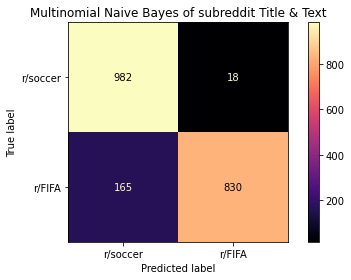

In [204]:
ConfusionMatrixDisplay.from_predictions(y_test, preds, cmap = 'magma', display_labels = ['r/soccer', 'r/FIFA'])
plt.title('Multinomial Naive Bayes of subreddit Title & Text')

plt.tight_layout()
plt.savefig('../images/mnb_title_text_cmatrix');

In [205]:
#Accuracy
(tp + tn) / (tp + fn + fp + tn)

0.9082706766917293

In [206]:
#Sensitivity (Recall)
tp / (tp + fn)

0.8341708542713567

In [207]:
#Specificity
tn / (tn + fp)

0.982

This model, which took the combined title and texts was slightly less accurate than our previous model, with an Accuracy of 90.8%, but our specificity (which minimizes false positives) is 98.2%.

In [208]:
misplaced_preds = pd.DataFrame([(y_test.values[i], preds[i]) for i in range(len(y_test)) if y_test.values[i] != preds[i]],
             index = [y_test.index[i] for i in range(len(y_test)) if y_test.values[i] != preds[i]])
misplaced_preds.rename(columns = {0:'misplaced_in_FIFA', 1:'misplaced_in_soccer'}, inplace = True)

In [209]:
misplaced_titles = pd.DataFrame(X_test.loc[[y_test.index[i] for i in range(len(y_test)) if y_test.values[i] != preds[i]]])

In [210]:
misplaced_combined_titles = pd.concat([misplaced_preds, misplaced_titles], axis = 1)
misplaced_combined_titles.sort_index()

,misplaced_in_FIFA,misplaced_in_soccer,text_and_title
2,1,0,[record] cristiano ronaldo says he will be at ...
9,1,0,[statsbomb] ellyes skhiri percentile rank vs. ...
49,1,0,"i’ve never played soccer, but the ball has suc..."
92,1,0,a throwback to a thread 9 years ago asking who...
99,1,0,does someone need an perfect football/soccer e...
...,...,...,...
6469,0,1,would you go with cunha or diaz on this?tough ...
6701,0,1,[deleted]i wish for more that i can get
6802,0,1,this was not called a foul/handball apparently
7436,0,1,i miss the old practice arena


### Tfidf

In [211]:
#Reset DataFrame
df = pd.read_csv('../data/combined_reddit.csv')
df.fillna('', inplace = True)
df['subreddit'] = df['subreddit'].map({'soccer':1, 'FIFA':0})

pattern = '(\\n)+[\* ]'
def remove_html(post):
    post = post.lower()
    return re.sub(pattern, ' ', post)

df['cleantext'] = df['cleantext'].apply(remove_html)
df['cleantitle'] = df['cleantitle'].apply(remove_html)
print(df.shape)
df.head()

(7978, 4)


,author,subreddit,cleantext,cleantitle
0,AutoModerator,1,a place to discuss everything except the engli...,non-pl daily discussion
1,Chapulana,1,,[about the latest eca/uefa idea] psg want cham...
2,joaorsilva,1,,[record] cristiano ronaldo says he will be at ...
3,klarstartpirat,1,,jack grealish says english players get unfair ...
4,ImamZain,1,,[pearce] the battle for jude bellingham… dortm...


In [212]:
#Reset X and y
X = df['cleantitle'] 
y = df['subreddit']

In [213]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify = y)

In [214]:
pipe_tvec = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

pipe_tvec_params = {
    'tvec__max_features': [2000, 3000, 4000, 5000],
    'tvec__stop_words': [None, 'english'],
    'tvec__ngram_range': [(1, 1), (1, 2)]
}

In [215]:
gs_tvec = GridSearchCV(pipe_tvec,
                       param_grid = pipe_tvec_params,
                       cv = 5)

In [216]:
gs_tvec.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('nb', MultinomialNB())]),
             param_grid={'tvec__max_features': [2000, 3000, 4000, 5000],
                         'tvec__ngram_range': [(1, 1), (1, 2)],
                         'tvec__stop_words': [None, 'english']})

In [217]:
print(gs_tvec.best_score_)
print(gs_tvec.best_params_)

0.9354857321676542
{'tvec__max_features': 5000, 'tvec__ngram_range': (1, 2), 'tvec__stop_words': 'english'}


In [218]:
print(f'Training Score: {gs_tvec.score(X_train, y_train)}')
print(f'Testing Score: {gs_tvec.score(X_test, y_test)}')

Training Score: 0.9620591676416513
Testing Score: 0.9353383458646617


In [219]:
preds_tvec = gs_tvec.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, preds_tvec).ravel()

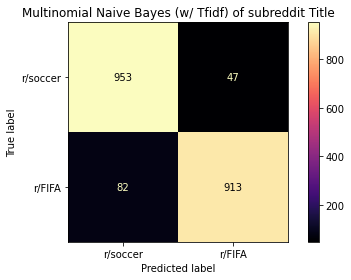

In [220]:
ConfusionMatrixDisplay.from_predictions(y_test, preds_tvec, cmap = 'magma', display_labels = ['r/soccer', 'r/FIFA'])
plt.title('Multinomial Naive Bayes (w/ Tfidf) of subreddit Title')

plt.tight_layout()
plt.savefig('../images/mnb_tvec_title');

In [221]:
#Accuracy
(tp + tn) / (tp + fn + fp + tn)

0.9353383458646617

In [222]:
#Sensitivity (Recall)
tp / (tp + fn)

0.9175879396984925

In [223]:
#Specificity
tn / (tn + fp)

0.953

Accuracy for the Tfidf is 93.5%

In [224]:
misplaced_preds = pd.DataFrame([(y_test.values[i], preds_tvec[i]) for i in range(len(y_test)) if y_test.values[i] != preds_tvec[i]],
             index = [y_test.index[i] for i in range(len(y_test)) if y_test.values[i] != preds_tvec[i]])
misplaced_preds.rename(columns = {0:'misplaced_in_FIFA', 1:'misplaced_in_soccer'}, inplace = True)

In [225]:
misplaced_titles = pd.DataFrame(X_test.loc[[y_test.index[i] for i in range(len(y_test)) if y_test.values[i] != preds_tvec[i]]])

In [226]:
misplaced_combined_titles = pd.concat([misplaced_preds, misplaced_titles], axis = 1)
misplaced_combined_titles.sort_index()

,misplaced_in_FIFA,misplaced_in_soccer,cleantitle
9,1,0,[statsbomb] ellyes skhiri percentile rank vs. ...
49,1,0,"i’ve never played soccer, but the ball has suc..."
99,1,0,does someone need an perfect football/soccer e...
112,1,0,what cleats are these?
120,1,0,the most decisive players in a season in the 2...
...,...,...,...
7525,0,1,"dda at its worst. 120' minute equalizer, conte..."
7669,0,1,i would pay for classic teams or even better c...
7682,0,1,wonder - volley
7787,0,1,my entry for this year’s fallon d’floor.


## RandomForests

In [227]:
#Reset DataFrame
df = pd.read_csv('../data/combined_reddit.csv')
df.fillna('', inplace = True)
df['subreddit'] = df['subreddit'].map({'soccer':1, 'FIFA':0})
print(df.shape)
df.head()

(7978, 4)


,author,subreddit,cleantext,cleantitle
0,AutoModerator,1,a place to discuss everything except the engli...,non-pl daily discussion
1,Chapulana,1,,[about the latest eca/uefa idea] psg want cham...
2,joaorsilva,1,,[record] cristiano ronaldo says he will be at ...
3,klarstartpirat,1,,jack grealish says english players get unfair ...
4,ImamZain,1,,[pearce] the battle for jude bellingham… dortm...


In [228]:
#Reset X and y
X = df['cleantitle'] 
y = df['subreddit']

In [229]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify = y)

In [230]:
pipe2 = Pipeline([
    ('cvec', CountVectorizer()),
    ('rf', RandomForestClassifier())
])

In [231]:
pipe2_params = {
    'cvec__stop_words':[None, 'english'],
    'rf__n_estimators': [50, 100, 200, 500]
}

In [232]:
gs2 = GridSearchCV(pipe2,
                  param_grid = pipe2_params,
                  cv = 5)

In [233]:
gs2.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('rf', RandomForestClassifier())]),
             param_grid={'cvec__stop_words': [None, 'english'],
                         'rf__n_estimators': [50, 100, 200, 500]})

In [234]:
print(gs2.best_score_)
print(gs2.best_params_)

0.9107498400404579
{'cvec__stop_words': None, 'rf__n_estimators': 500}


Our best parameters were when we do not remove English stop words, and had n_estimators (number of trees in the forest) equal to 500.

In [235]:
print(f'Training Score: {gs2.score(X_train, y_train)}')
print(f'Testing Score: {gs2.score(X_test, y_test)}')

Training Score: 0.999331439077386
Testing Score: 0.9167919799498747


Model appears to be overfit, as we have a score of .999 for the training set, but .917 for the testing set.

In [236]:
preds = gs2.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

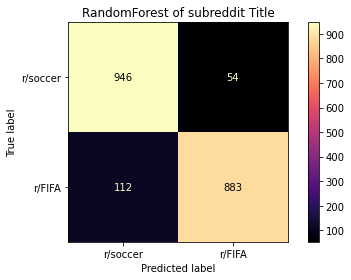

In [237]:
ConfusionMatrixDisplay.from_predictions(y_test, preds, cmap = 'magma', display_labels = ['r/soccer', 'r/FIFA'])
plt.title('RandomForest of subreddit Title')

plt.tight_layout()
plt.savefig('../images/rf_title');

In [238]:
misplaced_preds = pd.DataFrame([(y_test.values[i], preds[i]) for i in range(len(y_test)) if y_test.values[i] != preds[i]],
             index = [y_test.index[i] for i in range(len(y_test)) if y_test.values[i] != preds[i]])
misplaced_preds.rename(columns = {0:'misplaced_in_FIFA', 1:'misplaced_in_soccer'}, inplace = True)

In [239]:
misplaced_titles = pd.DataFrame(X_test.loc[[y_test.index[i] for i in range(len(y_test)) if y_test.values[i] != preds[i]]])

In [240]:
misplaced_combined_titles = pd.concat([misplaced_preds, misplaced_titles], axis = 1)
misplaced_combined_titles.sort_index()

,misplaced_in_FIFA,misplaced_in_soccer,cleantitle
9,1,0,[statsbomb] ellyes skhiri percentile rank vs. ...
85,1,0,"vinicius junior, racist abuse and yet 'everyth..."
92,1,0,a throwback to a thread 9 years ago asking who...
112,1,0,what cleats are these?
136,1,0,"pedri: i'm proud to play with lewandowski."""
...,...,...,...
7670,0,1,3 bars of power on a chip and he launches the ...
7765,0,1,last ditch slide
7766,0,1,beta setting file corrupt following update
7894,0,1,finally a great pull :)


In [241]:
#Accuracy
(tp + tn) / (tp + fn + fp + tn)

0.9167919799498747

In [242]:
#Sensitivity (Recall)
tp / (tp + fn)

0.8874371859296483

In [243]:
#Specificity
tn / (tn + fp)

0.946

The accuracy for this model is 91.6%. It also has a higher specificity than our Mutlinomial Naive Bayes, with a score of 94.6%, but our recall is 88.7%. This model was not good at minimizing false negatives.

### Combination of Text and Title

In [244]:
combine = df
combine['text_and_title'] = combine['cleantext'] + combine['cleantitle']
combine.drop(columns = ['cleantext', 'cleantitle'], inplace = True)
combine

,author,subreddit,text_and_title
0,AutoModerator,1,a place to discuss everything except the engli...
1,Chapulana,1,[about the latest eca/uefa idea] psg want cham...
2,joaorsilva,1,[record] cristiano ronaldo says he will be at ...
3,klarstartpirat,1,jack grealish says english players get unfair ...
4,ImamZain,1,[pearce] the battle for jude bellingham… dortm...
...,...,...,...
7973,AdamMitchellWheyyyy,0,"hey all\n\nas per the title, my connection is ..."
7974,Access_Kind,0,i am seeking advice on possible players to get...
7975,YakCarlo,0,fut 19 toty kit for anyone who wants a classy ...
7976,Access_Kind,0,need advice on my ligue 1 fut


In [245]:
#Set X and y
X = combine['text_and_title'] 
y = combine['subreddit']

In [246]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify = y)

In [247]:
pipe2 = Pipeline([
    ('cvec', CountVectorizer()),
    ('rf', RandomForestClassifier())
])

pipe2_params = {
    'cvec__stop_words':[None, 'english'],
    'rf__n_estimators': [50, 100, 200, 500],
    'rf__min_samples_leaf': [1, 2, 3, 5],
}

gs2 = GridSearchCV(pipe2,
                  param_grid = pipe2_params,
                  cv = 5)

In [248]:
gs2.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('rf', RandomForestClassifier())]),
             param_grid={'cvec__stop_words': [None, 'english'],
                         'rf__min_samples_leaf': [1, 2, 3, 5],
                         'rf__n_estimators': [50, 100, 200, 500]})

In [249]:
print(gs2.best_score_)
print(gs2.best_params_)

0.8995511353634923
{'cvec__stop_words': 'english', 'rf__min_samples_leaf': 2, 'rf__n_estimators': 200}


In [250]:
print(f'Training Score: {gs2.score(X_train, y_train)}')
print(f'Testing Score: {gs2.score(X_test, y_test)}')

Training Score: 0.9379909744275448
Testing Score: 0.8912280701754386


Less overfit, our training score is now .938, and our testing score is .891

In [251]:
preds = gs2.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

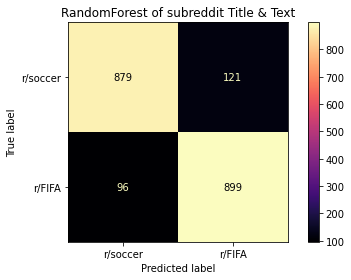

In [252]:
ConfusionMatrixDisplay.from_predictions(y_test, preds, cmap = 'magma', display_labels = ['r/soccer', 'r/FIFA'])
plt.title('RandomForest of subreddit Title & Text')

plt.tight_layout()
plt.savefig('../images/rf_title_text');

In [253]:
#Accuracy
(tp + tn) / (tp + fn + fp + tn)

0.8912280701754386

In [254]:
#Sensitivity (Recall)
tp / (tp + fn)

0.9035175879396985

In [255]:
#Specificity
tn / (tn + fp)

0.879

Accuracy is 89.1%. Unlike other models, we have a higher rate of false positives, and a lower rate of false negatives compared to the Multinomial Naive Bayes model.